In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import os
import sys

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, make_scorer


%matplotlib inline

In [2]:
class GBDT_model():
    def __init__(self, **kwargs):
        self.loss = kwargs.get('loss', 'ls')
        self.learning_rate = kwargs.get('learning_rate', 0.15)
        self.subsample = kwargs.get('subsample', 1.0)
        self.max_depth = kwargs.get('max_depth', 2)
        self.n_estimators = kwargs.get('n_estimators', 150)
        self.max_leaf_nodes = kwargs.get('max_leaf_nodes', None)
        self.min_samples_leaf = kwargs.get('min_samples_leaf', 3)
        self.min_samples_split = kwargs.get('min_samples_split', 5)
        self.alpha = kwargs.get('alpha', 0.9)
        
        self.model = None


    def opt_hyper_grid(self, x, y, param_space, num_sets: int=5):

        print('Finding best hyper-parameters for the model...')
        estimator = GradientBoostingRegressor(loss=self.loss, learning_rate=self.learning_rate,
                                              subsample=self.subsample, max_depth=self.max_depth,
                                              n_estimators=self.n_estimators,
                                              max_leaf_nodes=self.max_leaf_nodes,
                                              min_samples_leaf=self.min_samples_leaf,
                                              min_samples_split=self.min_samples_split,
                                              alpha=self.alpha)
        gbdt = GridSearchCV(estimator=estimator, 
                            param_grid=param_space, 
                            cv=KFold(n_splits=num_sets, shuffle=True), 
                            scoring='neg_mean_absolute_error')
        grid_result = gbdt.fit(x, y)

        means = grid_result.cv_results_['mean_test_score']
        params = grid_result.cv_results_['params']

        for mean, param in zip(means, params):
            print("%f  with:   %r" % (mean, param))

        best_params = gbdt.best_params_
        print('Best params set:', best_params)
        print('Minimum mean absolute error:', -np.max(means))
        print('---------------------------------------------------')
        
        self.learning_rate = best_params.get('learning_rate', self.learning_rate)
        self.max_depth = best_params.get('max_depth', self.max_depth)
        self.subsample = best_params.get('subsample', self.subsample)
        self.n_estimators = best_params.get('n_estimators', self.n_estimators)
        self.max_leaf_nodes = best_params.get('max_leaf_nodes', self.max_leaf_nodes)
        self.min_samples_leaf = best_params.get('min_samples_leaf', self.min_samples_leaf)
        self.min_samples_split = best_params.get('min_samples_split', self.min_samples_split)
        self.alpha = best_params.get('alpha', self.alpha)
 


    def build_model(self, x, y, params, grid_search: bool = True):
        """
        If use grid search, then each parameter can have multiple values
        
        Example: params = {'learning_rate': [0.1, 0.3],
                           'n_estimators': [100, 200, 300]
                           }
                           
        If do not use grid search, then each parameter should have only one value
        
        Example: params = {'learning_rate': 0.1,
                           'n_estimators': 100
                          }
        
        """
        
        
        if grid_search:
            self.opt_hyper_grid(x, y, params)
        else:

            self.learning_rate = params.get('learning_rate', self.learning_rate)
            self.max_depth = params.get('max_depth', self.max_depth)
            self.subsample = params.get('subsample', self.subsample)
            self.n_estimators = params.get('n_estimators', self.n_estimators)
            self.max_leaf_nodes = params.get('max_leaf_nodes', self.max_leaf_nodes)
            self.min_samples_leaf = params.get('min_samples_leaf', self.min_samples_leaf)
            self.min_samples_split = params.get('min_samples_split', self.min_samples_split)
            self.alpha = params.get('alpha', self.alpha)

        gbdt = GradientBoostingRegressor(loss=self.loss, learning_rate=self.learning_rate,
                                         subsample=self.subsample, max_depth=self.max_depth,
                                         n_estimators=self.n_estimators,
                                         max_leaf_nodes=self.max_leaf_nodes,
                                         min_samples_leaf=self.min_samples_leaf,
                                         min_samples_split=self.min_samples_split, alpha=self.alpha)
        # 10 fold cross-validation
        sk = KFold(n_splits=10, shuffle=True)
        scores_train = list()
        scores_val = list()
        for train_ind, val_ind in sk.split(x, y):
            train_x = x.iloc[train_ind].values
            train_y = y.iloc[train_ind]
            val_x = x.iloc[val_ind].values
            val_y = y.iloc[val_ind]

            gbdt.fit(train_x, train_y)
            pred_train_gbdt = gbdt.predict(train_x)
            pred_val_gbdt = gbdt.predict(val_x)

            score_train = mean_absolute_error(train_y, pred_train_gbdt)
            scores_train.append(score_train)
            score_val = mean_absolute_error(val_y, pred_val_gbdt)
            scores_val.append(score_val)
        
        print('Train mean absolute error:', np.mean(scores_train))
        print('Val mean absolute error:', np.mean(scores_val))
        print("Train score: ", scores_train)
        print("Validation score: ", scores_val)
        
        self.model = gbdt
        return gbdt, scores_train, scores_val

    def save_model(self, model_path):
        print('Saving model...')
        joblib.dump(self.model, model_path)
        print('Model saved.')


    def predict_with_model(self, x_test):
        y_test_pred = self.model.predict(x_test)
        return y_test_pred

In [5]:
# Load the data
BTC_BUSD = pd.read_csv("../Data/BTC2.csv")

In [6]:
# Check if there is any NaN values
for col_name, _ in BTC_BUSD.iteritems():
    if len(BTC_BUSD[BTC_BUSD[col_name].isna()])>0:
        print("%s: %s rows" % (col_name, len(BTC_BUSD[BTC_BUSD[col_name].isna()])))

Text(0, 0.5, 'BTC-BUSD close price')

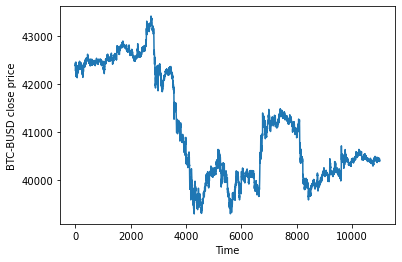

In [7]:
# Show the plot
plt.plot(BTC_BUSD['close'])
plt.xlabel('Time')
plt.ylabel('BTC-BUSD close price')

## Use Twitter data for price prediction

In [8]:
# Option 1: Use all features
BTC_BUSD_copy = BTC_BUSD.copy()
BTC_BUSD_copy.reset_index(drop=True, inplace=True)
BTC_BUSD_copy.head()

,open_time,avg,wgtavg,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2022-04-08 22:33:00,0.106600,-0.076148,42409.00,42409.01,42367.01,42384.64,3.75072,158990.77,254,1.41116,59816.070
1,2022-04-08 22:34:00,0.228277,0.047320,42384.63,42387.50,42344.08,42373.66,5.21452,220892.70,229,1.48407,62871.580
2,2022-04-08 22:35:00,0.142080,0.078871,42369.76,42424.41,42369.75,42415.69,5.10597,216482.45,213,3.03908,128832.950
3,2022-04-08 22:36:00,0.207449,0.232077,42415.68,42453.85,42415.42,42439.52,5.04461,214064.31,252,3.75288,159234.840
4,2022-04-08 22:37:00,0.163528,0.358569,42439.51,42451.54,42412.62,42415.94,2.93812,124666.83,162,0.69743,29594.648


In [11]:
# Train models
# Determine if grid search is necessary
grid_search = False

# Determine if we want to save the new trained models
save_model = False


# Set predict time (e.g. m=5 represents "5 minutes later")
for m in range(1, 6):
    
    print("Start build model to predcit price %d minutes later........." % (m))
    
    # Set target predict price (m minutes later)
    target_price = BTC_BUSD_copy['close'].shift(-m, fill_value=BTC_BUSD_copy['close'].iloc[-1]).rename("price_m_min_later")
    target_price_diff = (target_price - BTC_BUSD_copy['close']).rename("price_diff_m_min_later")
    # Get dataset
    dataset = pd.concat([BTC_BUSD_copy, target_price, target_price_diff], axis=1)
    


    # Determine if we want to predict price difference
    diff = True

    if diff:
        X_train = dataset.iloc[:, 1:-2]

        # Use price difference as the target
        Y_train = dataset.iloc[:, -1]

    else:
        X_train = dataset.iloc[:, 1:-2]

        # Use future price as the target
        Y_train = dataset.iloc[:, -2]





    # With hyperparameter grid search
    if grid_search:
        task = GBDT_model()

        params = {'learning_rate': [0.05, 0.08, 0.1, 0.3],
                  'max_depth': [2,3],
                  'n_estimators': [100, 150, 200]

        }

        gbdt_reg, scores_train, scores_val = task.build_model(X_train, Y_train, params, grid_search=True)
#         Y_test_pred = task.predict_with_model(X_test)
#         print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))

    # Without hyperparameter grid search
    else:
        task = GBDT_model()

        params = {'learning_rate': 0.1, 
                  'max_depth': 2,
                  'n_estimators': 200

        }

        gbdt_reg, scores_train, scores_val = task.build_model(X_train, Y_train, params, grid_search=False)
#         Y_test_pred = task.predict_with_model(X_test)
#         print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))

    # Save model
    if save_model:

        save_path = "Models/gbdt_" + str(m) + "_minutes_later.pkl"
        task.save_model(save_path)

    print("=" * 50)


Start build model to predcit price 1 minutes later.........
Train mean absolute error: 17.05298563121333
Val mean absolute error: 17.815570539964412
Train score:  [17.001357892852592, 17.11774542260984, 17.04480089058088, 17.06490919566868, 16.99319677856944, 17.076935084562667, 17.137007080886548, 17.062286459092206, 17.095322128406934, 16.936295378903495]
Validation score:  [18.666126747540396, 16.940092811027995, 18.058161693460274, 17.815455056925018, 18.154609939189736, 17.631873238327465, 16.960283956586284, 17.320151989978072, 17.331451882483734, 19.277498084125142]
Start build model to predcit price 2 minutes later.........
Train mean absolute error: 24.369794448982194
Val mean absolute error: 25.444159907605304
Train score:  [24.423114973046967, 24.39460710469345, 24.23924518010215, 24.467099367454715, 24.34139358153773, 24.26172780441764, 24.412596089331213, 24.346241164928436, 24.43410149163837, 24.377817732671282]
Validation score:  [24.972705929592966, 25.230875851568968, 

In [12]:
# Load saved models
gbdt_models = []
m_min, m_max = 1, 5
for m in range(m_min, m_max+1):
    load_path = "Models/gbdt_" + str(m) + "_minutes_later.pkl"
    if os.path.exists(load_path):
        gbdt_models.append(joblib.load(load_path))
    else:
        print("Warning: model %d does not found." % (m))

In [13]:
# Evaluate validation set performance of each fold in cross-validation
N = len(BTC_BUSD_copy)
s_points = np.linspace(0, N, 11, dtype=int)

mae_error_list, mape_error_list = [], []
for i in range(len(s_points)-1):
    st_point = s_points[i]
    weights = [(m-i)/np.sum(np.arange(m+1)) for i in range(m)]
    pred_length = s_points[i+1] - s_points[i]
    price_pred = []
    for i in range(pred_length):
        cur_sum = 0
        cur_portion = 0
        for j in range(m):
            if st_point-((j+m)-i) < st_point + pred_length:
                cur_sum += weights[j] * (gbdt_models[j].predict(BTC_BUSD_copy.iloc[st_point-((j+m)-i), 1:].values.reshape(1,-1)) + BTC_BUSD_copy.iloc[st_point-((j+m)-i)]['close'])[0]
                cur_portion += weights[j]
        price_pred.append(cur_sum / cur_portion if cur_portion !=0 else 0)

    price_true = BTC_BUSD_copy.iloc[st_point:st_point+pred_length]['close'].values
    mae_error_list.append(mean_absolute_error(price_true, price_pred))
    mape_error_list.append(mean_absolute_percentage_error(price_true, price_pred))
print("MAE: ", mae_error_list)
print("MAPE: ", mape_error_list)

MAE:  [44.22770881429972, 24.3926140898651, 46.623231062481125, 65.49519065272138, 52.513553994238464, 49.194332374394776, 47.39944757797716, 43.75811254295898, 35.78723113364603, 19.865339125160624]
MAPE:  [0.0010432416500189019, 0.0005721012896751488, 0.0010957264040312713, 0.0016108771100054927, 0.0013121454171148405, 0.00123365168821436, 0.001156086787283365, 0.0010831830410470676, 0.0008890360798509323, 0.000491114675716053]


In [16]:
print("Mean MAE: ", np.average(mae_error_list))
print("Man MAPE: ", np.average(mape_error_list))

Mean MAE:  42.925676136774335
Man MAPE:  0.0010487164142957432


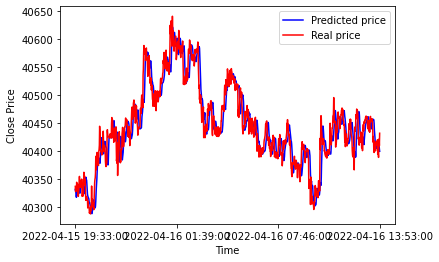

In [18]:
# Show results
%matplotlib inline
plt.plot(BTC_BUSD_copy.iloc[st_point:st_point+pred_length]['open_time'], price_pred,'b', label='Predicted price')
plt.plot(BTC_BUSD_copy.iloc[st_point:st_point+pred_length]['open_time'], price_true, 'r', label="Real price")
plt.legend()
plt.xlabel("Time")
plt.xticks([BTC_BUSD_copy.iloc[i]['open_time'] for i in np.linspace(st_point, st_point+pred_length-1, 4, dtype=int)])
plt.ylabel("Close Price")
plt.show()

## Do not use Twitter Data

In [19]:
# Option 2: Do not use twitter information
BTC_BUSD_copy2 = BTC_BUSD.copy().drop(labels=['avg','wgtavg'],axis=1)
BTC_BUSD_copy2.reset_index(drop=True, inplace=True)
BTC_BUSD_copy2.head()

,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2022-04-08 22:33:00,42409.00,42409.01,42367.01,42384.64,3.75072,158990.77,254,1.41116,59816.070
1,2022-04-08 22:34:00,42384.63,42387.50,42344.08,42373.66,5.21452,220892.70,229,1.48407,62871.580
2,2022-04-08 22:35:00,42369.76,42424.41,42369.75,42415.69,5.10597,216482.45,213,3.03908,128832.950
3,2022-04-08 22:36:00,42415.68,42453.85,42415.42,42439.52,5.04461,214064.31,252,3.75288,159234.840
4,2022-04-08 22:37:00,42439.51,42451.54,42412.62,42415.94,2.93812,124666.83,162,0.69743,29594.648


In [21]:
# Determine if grid search is necessary
grid_search = False

# Determine if we want to save the new trained models
save_model = True


# Set predict time (e.g. m=5 represents "5 minutes later")
for m in range(1, 6):
    
    print("Start build model to predcit price %d minutes later........." % (m))
    
    # Set target predict price (m minutes later)
    target_price = BTC_BUSD_copy2['close'].shift(-m, fill_value=BTC_BUSD_copy2['close'].iloc[-1]).rename("price_m_min_later")
    target_price_diff = (target_price - BTC_BUSD_copy2['close']).rename("price_diff_m_min_later")
    # Get dataset
    dataset = pd.concat([BTC_BUSD_copy2, target_price, target_price_diff], axis=1)
    


    # Determine if we want to predict price difference
    diff = True

    if diff:
        X_train = dataset.iloc[:, 1:-2]

        # Use price difference as the target
        Y_train = dataset.iloc[:, -1]

    else:
        X_train = dataset.iloc[:, 1:-2]

        # Use future price as the target
        Y_train = dataset.iloc[:, -2]





    # With hyperparameter grid search
    if grid_search:
        task = GBDT_model()

        params = {'learning_rate': [0.05, 0.1, 0.3],
                  'max_depth': [2,3],
                  'n_estimators': [100, 150, 200]

        }

        gbdt_reg, scores_train, scores_val = task.build_model(X_train, Y_train, params, grid_search=True)
#         Y_test_pred = task.predict_with_model(X_test)
#         print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))

    # Without hyperparameter grid search
    else:
        task = GBDT_model()

        params = {'learning_rate': 0.1, 
                  'max_depth': 3,
                  'n_estimators': 200

        }

        gbdt_reg, scores_train, scores_val = task.build_model(X_train, Y_train, params, grid_search=False)
#         Y_test_pred = task.predict_with_model(X_test)
#         print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))

    # Save model
    if save_model:

        save_path = "Models/gbdt_" + str(m) + "_minutes_later_no_twitter_try.pkl"
        task.save_model(save_path)

    print("=" * 50)


Start build model to predcit price 1 minutes later.........
Train mean absolute error: 16.48662857113228
Val mean absolute error: 17.89065388330573
Train score:  [16.450683920816658, 16.383526020517188, 16.48488901836696, 16.47947928109444, 16.50162531590446, 16.617294779665507, 16.501501204696712, 16.434873039690164, 16.546211043346954, 16.466202087223746]
Validation score:  [17.80788150717122, 18.76620747374483, 18.029252595506584, 17.661407010008087, 17.55088868964709, 16.994142493531303, 18.073755919501764, 18.62815317159785, 17.500637089535733, 17.89421288281284]
Saving model...
Model saved.
Start build model to predcit price 2 minutes later.........
Train mean absolute error: 23.538007464160415
Val mean absolute error: 25.602037603185078
Train score:  [23.466914868385835, 23.36378672520409, 23.457472865589587, 23.678048944194646, 23.48502746432569, 23.432988131165143, 23.7071010937802, 23.632462276570326, 23.609603137094968, 23.546669135293644]
Validation score:  [26.211294987291

In [22]:
gbdt_models_nt = []
m_min, m_max = 1, 5
for m in range(m_min, m_max+1):
    load_path = "Models/gbdt_" + str(m) + "_minutes_later_no_twitter_try.pkl"
    if os.path.exists(load_path):
        gbdt_models_nt.append(joblib.load(load_path))
    else:
        print("Warning: model %d does not found." % (m))

In [23]:
N = len(BTC_BUSD_copy2)
s_points = np.linspace(0, N, 11, dtype=int)

mae_error_list, mape_error_list = [], []
for i in range(len(s_points)-1):
    st_point = s_points[i]
    weights = [(m-i)/np.sum(np.arange(m+1)) for i in range(m)]
    pred_length = s_points[i+1] - s_points[i]
    price_pred2 = []
    for i in range(pred_length):
        cur_sum = 0
        cur_portion = 0
        for j in range(m):
            if st_point-((j+m)-i) < st_point + pred_length:
                cur_sum += weights[j] * (gbdt_models_nt[j].predict(BTC_BUSD_copy2.iloc[st_point-((j+m)-i), 1:].values.reshape(1,-1)) + BTC_BUSD_copy2.iloc[st_point-((j+m)-i)]['close'])[0]
                cur_portion += weights[j]
        price_pred2.append(cur_sum / cur_portion if cur_portion !=0 else 0)

    price_true = BTC_BUSD_copy2.iloc[st_point:st_point+pred_length]['close'].values
    mae_error_list.append(mean_absolute_error(price_true, price_pred2))
    mape_error_list.append(mean_absolute_percentage_error(price_true, price_pred2))
print("MAE: ", mae_error_list)
print("MAPE: ", mape_error_list)

MAE:  [44.08338950351387, 24.283190331533643, 45.37733148872487, 64.00992652057762, 51.4012262431389, 48.021085049873165, 46.69211141744615, 42.9320349822609, 35.1667607762969, 19.728750033518523]
MAPE:  [0.0010398427262132066, 0.0005695395344634807, 0.0010665379092334598, 0.001574153570559623, 0.0012842927063700478, 0.0012041181182409779, 0.001138826610787532, 0.0010627606576343244, 0.0008736496673599315, 0.0004877416480490444]


In [24]:
print("Mean MAE: ", np.average(mae_error_list))
print("Man MAPE: ", np.average(mape_error_list))

Mean MAE:  42.16958063468845
Man MAPE:  0.001030146314891163


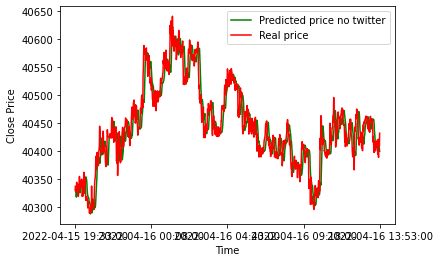

In [25]:
plt.plot(BTC_BUSD_copy2.iloc[st_point:st_point+pred_length]['open_time'], price_pred2,'g', label='Predicted price no twitter')
plt.plot(BTC_BUSD_copy2.iloc[st_point:st_point+pred_length]['open_time'], price_true, 'r', label="Real price")
plt.legend()
plt.xlabel("Time")
plt.xticks([BTC_BUSD_copy.iloc[i]['open_time'] for i in np.linspace(st_point, st_point+pred_length-1, 5, dtype=int)])
plt.ylabel("Close Price")
plt.show()

## Compare the results with and without Twitter data

In [26]:
N = len(BTC_BUSD_copy)
st_point = 10200
pred_length = 300

for i in range(len(s_points)-1):
    weights = [(m-i)/np.sum(np.arange(m+1)) for i in range(m)]
    price_pred_all = []
    for i in range(pred_length):
        cur_sum = 0
        cur_portion = 0
        for j in range(m):
            if st_point-((j+m)-i) < st_point + pred_length:
                cur_sum += weights[j] * (gbdt_models[j].predict(BTC_BUSD_copy.iloc[st_point-((j+m)-i), 1:].values.reshape(1,-1)) + BTC_BUSD_copy.iloc[st_point-((j+m)-i)]['close'])[0]
                cur_portion += weights[j]
        price_pred_all.append(cur_sum / cur_portion if cur_portion !=0 else 0)

for i in range(len(s_points)-1):
    weights = [(m-i)/np.sum(np.arange(m+1)) for i in range(m)]
    price_pred2_all = []
    for i in range(pred_length):
        cur_sum = 0
        cur_portion = 0
        for j in range(m):
            if st_point-((j+m)-i) < st_point + pred_length:
                cur_sum += weights[j] * (gbdt_models_nt[j].predict(BTC_BUSD_copy2.iloc[st_point-((j+m)-i), 1:].values.reshape(1,-1)) + BTC_BUSD_copy2.iloc[st_point-((j+m)-i)]['close'])[0]
                cur_portion += weights[j]
        price_pred2_all.append(cur_sum / cur_portion if cur_portion !=0 else 0)

In [27]:
price_true_all = BTC_BUSD_copy2.iloc[st_point:st_point+pred_length]['close'].values

Text(0, 0.5, 'Close Price')

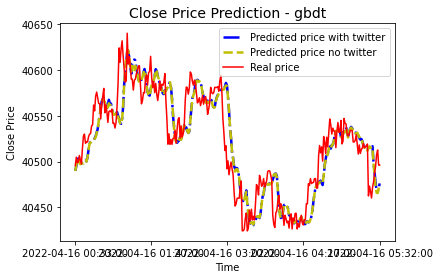

In [28]:
%matplotlib inline
plt.figure()
plt.plot(BTC_BUSD_copy2.iloc[st_point:st_point+pred_length]['open_time'], price_pred_all,'b-.', linewidth=2.5,label='Predicted price with twitter')
plt.plot(BTC_BUSD_copy2.iloc[st_point:st_point+pred_length]['open_time'], price_pred2_all,'y--', linewidth=2.5,label='Predicted price no twitter')
plt.plot(BTC_BUSD_copy2.iloc[st_point:st_point+pred_length]['open_time'], price_true_all, 'r', label="Real price")
plt.xticks([BTC_BUSD_copy2.iloc[i]['open_time'] for i in np.linspace(st_point, st_point+pred_length-1, 5, dtype=int)])
plt.legend()
plt.title("Close Price Prediction - gbdt", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Close Price")